# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [ ]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize
from sklearn.base import BaseEstimator

In [ ]:
class GradientBoosting (BaseEstimator):
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate

        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        self.storage = []
        self.tree = DecisionTreeRegressor(max_depth= self.max_depth)
        self.y_new = 0
        self.s = y
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        for i in range(self.n_estimators):
          self.y_new += self._fit_predict_tree(x, y)
          self.storage.append(self.tree)

            # your code here

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        self.gammas = []
        self.tree = DecisionTreeRegressor(max_depth= self.max_depth)
        self.s = y - self.y_new
        self.tree.fit(x, self.s)

        def shifted_error(gamma, a, b, c):
          error= a - (b + gamma * c)
          mse=np.mean(error**2)
          return mse

        self.gamma = minimize(shifted_error, 10, args=(y,self.y_new,self.tree.predict(x))).x
        self.gammas.append(self.gamma)

        return self.gamma * self.learning_rate * self.tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        self.y_pred = 0
        for i, gamma_i in zip(self.storage, self.gammas):
          self.y_pred += gamma_i * self.learning_rate * i.predict(x)
        return self.y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [ ]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [ ]:
np.random.seed(19052019)
boost = GradientBoosting(n_estimators = 400, max_depth = 10,learning_rate = 0.1)
boost.fit(X_train, y_train)
y_pred_2 = boost.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred_2)

15.011711482527998

Ну все, я сдохла, мсе тоже...

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
np.random.seed(19052019)
param_grid = {
    #'n_estimators': [200, 300, 400, 500, 600, 900],
    #'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

gb = GradientBoosting(n_estimators = 200, max_depth=10, learning_rate=None)
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, cv = 5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoosting(learning_rate=None, max_depth=10,
                                        n_estimators=200),
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9, 1]},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_estimator_

GradientBoosting(max_depth=10, n_estimators=200)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1}

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- **Да**.

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [ ]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [ ]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier()
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.7003453946096179

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
features_mask = (train.dtypes == 'object').values # с помощью маски "выбираем" из датасета категориальные переменные
df_categorical = train[train.columns[features_mask]]
df_real = train[train.columns[~features_mask]]

In [ ]:
df_categorical = df_categorical.apply(LabelEncoder().fit_transform) 

In [ ]:
df_final = pd.concat([df_real, df_categorical], axis=1)

In [ ]:
y = df_final['dep_delayed_15min']
dt = df_final.drop(columns='dep_delayed_15min')
dt_new = dt.apply(pd.to_numeric).values
y_target_new = y.apply(pd.to_numeric).to_numpy()

In [ ]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(dt_new, y_target_new, test_size=0.3)

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
param_grid_cat = {
    #'learning_rate':  np.arange(0.1, 0.5, 0.9)
    #'depth': [3, 5, 10]
    #'early_stopping_rounds': [1, 3, 5]
    #'min_data_in_leaf': [1000, 2000, 3000]
    'l2_leaf_reg': [100, 150, 200]}

cat = CatBoostClassifier()
grid_search_cat = GridSearchCV(estimator = cat, param_grid = param_grid_cat, n_jobs = 4, scoring='roc_auc')
grid_search_cat.fit(X_train_part, y_train_part)

0:	learn: 0.6146657	total: 18.2ms	remaining: 18.1s
1:	learn: 0.5188864	total: 32ms	remaining: 16s
2:	learn: 0.4494741	total: 45.7ms	remaining: 15.2s
3:	learn: 0.3960693	total: 61.2ms	remaining: 15.2s
4:	learn: 0.3333889	total: 72.2ms	remaining: 14.4s
5:	learn: 0.2899887	total: 86.7ms	remaining: 14.4s
6:	learn: 0.2507130	total: 103ms	remaining: 14.6s
7:	learn: 0.2236918	total: 119ms	remaining: 14.8s
8:	learn: 0.1948726	total: 133ms	remaining: 14.6s
9:	learn: 0.1739780	total: 148ms	remaining: 14.6s
10:	learn: 0.1518802	total: 161ms	remaining: 14.5s
11:	learn: 0.1341443	total: 177ms	remaining: 14.6s
12:	learn: 0.1183359	total: 193ms	remaining: 14.6s
13:	learn: 0.1043291	total: 207ms	remaining: 14.5s
14:	learn: 0.0925294	total: 228ms	remaining: 15s
15:	learn: 0.0851709	total: 246ms	remaining: 15.1s
16:	learn: 0.0761006	total: 262ms	remaining: 15.2s
17:	learn: 0.0667853	total: 275ms	remaining: 15s
18:	learn: 0.0607392	total: 291ms	remaining: 15s
19:	learn: 0.0534252	total: 303ms	remaining: 

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7f482cccbc10>,
             n_jobs=4, param_grid={'l2_leaf_reg': [100, 150, 200]},
             scoring='roc_auc')

In [ ]:
grid_search_cat.best_params_

{'l2_leaf_reg': 100}

In [ ]:
clf = CatBoostClassifier(learning_rate=0.1, depth = 5, early_stopping_rounds = 1, min_data_in_leaf = 1000, l2_leaf_reg = 100)
clf.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

0:	learn: 0.6415205	total: 47.7ms	remaining: 47.7s
1:	learn: 0.6020379	total: 67.5ms	remaining: 33.7s
2:	learn: 0.5704342	total: 85.3ms	remaining: 28.3s
3:	learn: 0.5475782	total: 104ms	remaining: 26s
4:	learn: 0.5281286	total: 135ms	remaining: 26.9s
5:	learn: 0.5142836	total: 182ms	remaining: 30.1s
6:	learn: 0.5002010	total: 231ms	remaining: 32.8s
7:	learn: 0.4908181	total: 287ms	remaining: 35.6s
8:	learn: 0.4826589	total: 304ms	remaining: 33.5s
9:	learn: 0.4764934	total: 323ms	remaining: 32s
10:	learn: 0.4720348	total: 352ms	remaining: 31.7s
11:	learn: 0.4681622	total: 374ms	remaining: 30.8s
12:	learn: 0.4650906	total: 392ms	remaining: 29.8s
13:	learn: 0.4622234	total: 414ms	remaining: 29.2s
14:	learn: 0.4600053	total: 447ms	remaining: 29.4s
15:	learn: 0.4578812	total: 498ms	remaining: 30.6s
16:	learn: 0.4561891	total: 537ms	remaining: 31.1s
17:	learn: 0.4548877	total: 604ms	remaining: 33s
18:	learn: 0.4535865	total: 646ms	remaining: 33.3s
19:	learn: 0.4521800	total: 665ms	remaining:

0.7397783621624122

Почти-почти 0,74))

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [ ]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [ ]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.group = 1

        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        self.X = X
        self.labels = [0]*len(X)

        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        for p in range(0, len(X)):
           if self.labels[p] == 0:
             neighbours = self.range_query(p)
             if len(neighbours) >= self.min_samples:
               self.grow_cluster(p, neighbours)
             else: 
               self.labels[p] = -1
        return self.labels


    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here
        self.labels[root] = self.group
        neighbours = set(neighbours)
        
        while neighbours:
          p = neighbours.pop()
          if self.labels[p] != self.group:
              n = self.range_query(p)
              self.labels[p] = self.group
              if len(n) >= self.min_samples:
                  neighbours.update(self.range_query(p))
        self.group += 1    


    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        mask = list(map(lambda i: self.dist(i, self.X[x]), self.X))
        points = [index for index, value in enumerate(mask) if value <= self.eps]
        return points

    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        return distance.euclidean(a, b)
        

Проверим себя на простом примере:

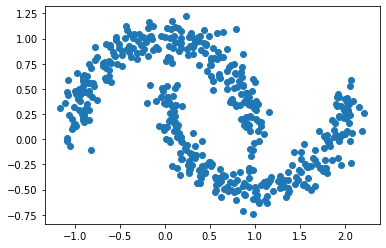

In [ ]:
from sklearn.datasets import make_moons
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

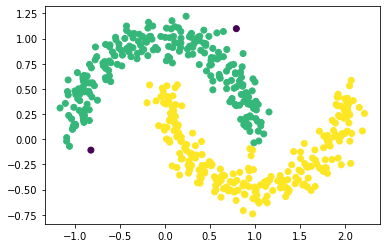

In [ ]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

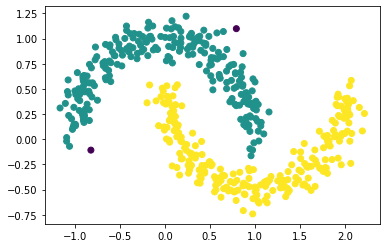

In [ ]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



In [ ]:
from sklearn.datasets import make_circles

In [ ]:
X1, y1 = datasets.make_circles(n_samples=1000, factor=0.35, noise=0.05)
X2, y2 = datasets.make_blobs(n_samples=1000, centers=[[0.45, 0.5]], cluster_std=[[0.03]])
X3, y3 = datasets.make_blobs(n_samples=1000, centers=[[-0.45, 0.5]], cluster_std=[[0.03]])

X = np.concatenate((X1, X2, X3))
noise_ponts =np.random.randn(100,2)
Noisy_Data=np.concatenate((X,noise_ponts))

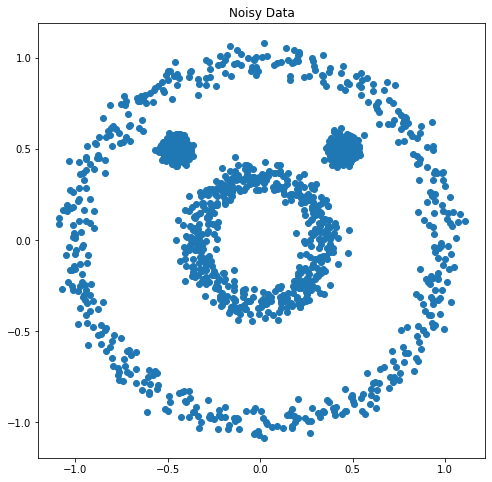

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.title("Noisy Data")
plt.show()

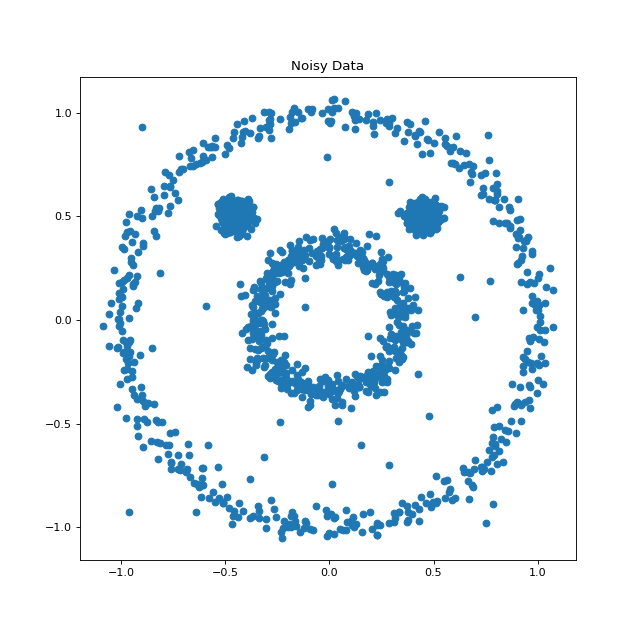


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [ ]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 9.7 ms, sys: 72 µs, total: 9.77 ms
Wall time: 9.45 ms


In [ ]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 5.66 s, sys: 14.9 ms, total: 5.68 s
Wall time: 5.73 s


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.DataFrame(train, columns=['Distance', 'DepTime'])

In [ ]:
ss = StandardScaler()
df = ss.fit_transform(df)

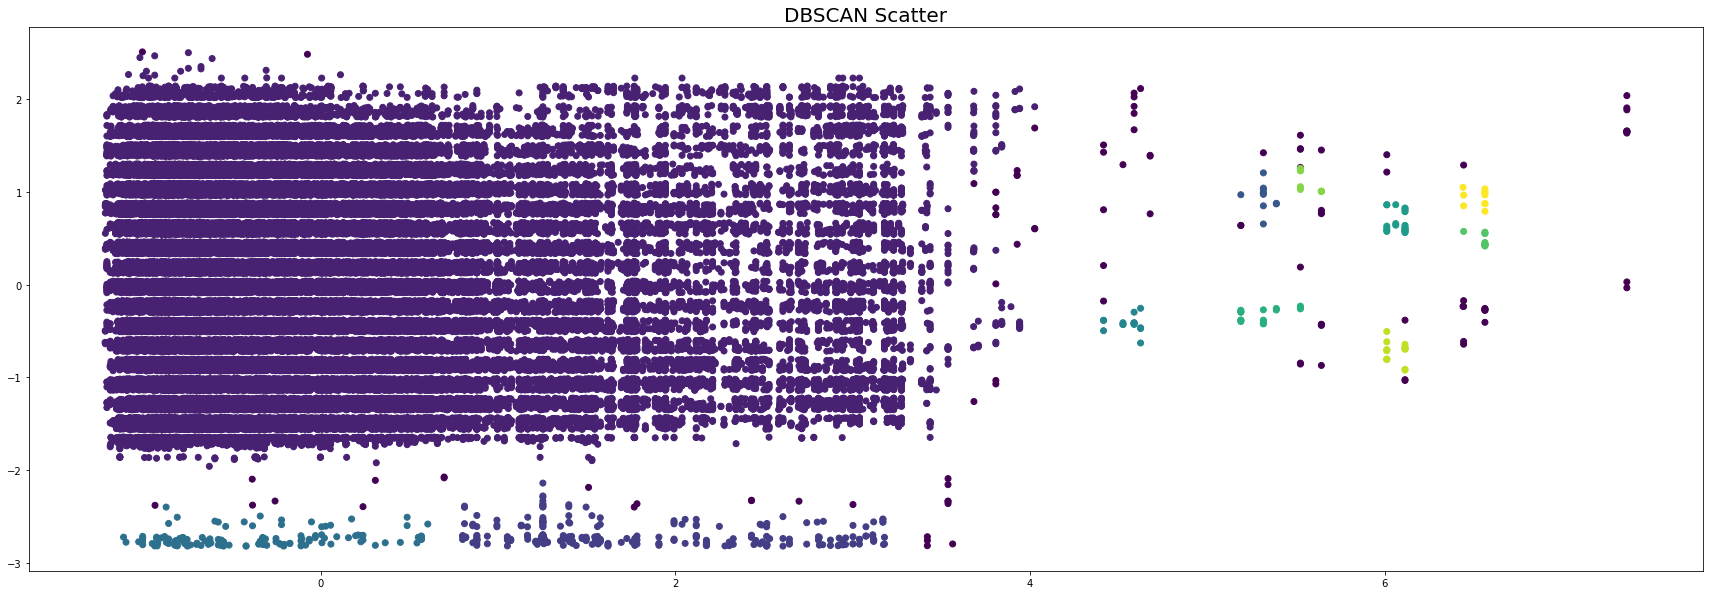

In [ ]:
from sklearn.cluster import DBSCAN
cls = DBSCAN(min_samples=10, eps = 0.2)
y = cls.fit_predict(df)
plt.figure(figsize= (30,10))
plt.scatter(df[:,0], df[:,1], c=y)
plt.title("DBSCAN Scatter", fontsize=20)
plt.show()

In [ ]:
np.unique(cls.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
unique, counts = np.unique(cls.labels_, return_counts=True)
result = np.column_stack((unique, counts)) 
print (result)

[[   -1   104]
 [    0 99384]
 [    1   257]
 [    2    11]
 [    3   138]
 [    4    16]
 [    5    22]
 [    6    19]
 [    7    12]
 [    8    11]
 [    9    16]
 [   10    10]]


In [ ]:
len(np.unique(cls.labels_)) - 1

11

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ В теории и по картинкам (перебор значений небольшой,иначе ОЗУ переполняется :(( больше всего точек оказывается при маленьком eps и большом min_samples, потому что вероятность того, что в окрестность eps точки попадут n_min объектов, в том числе хотя бы одна основная точка, уменьшается.  

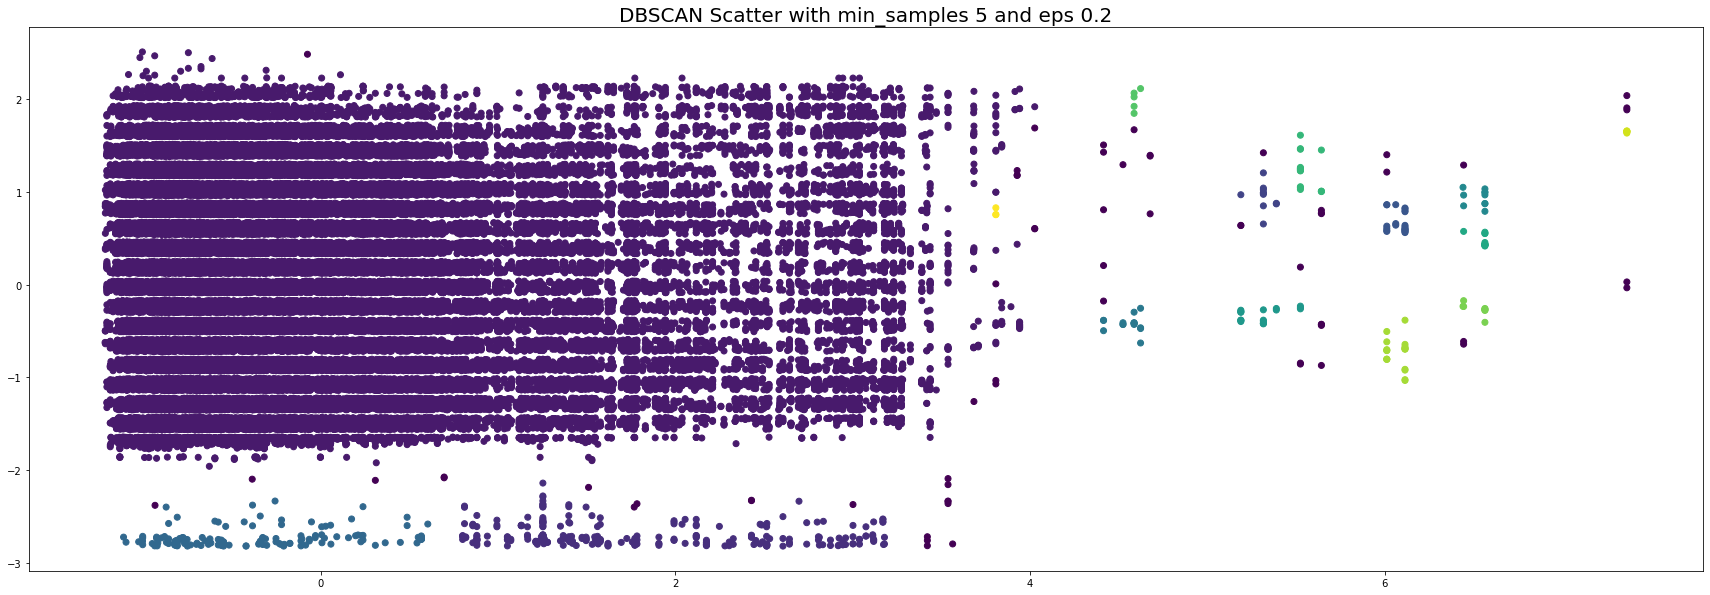

[[   -1    64]
 [    0 99389]
 [    1   258]
 [    2    11]
 [    3    22]
 [    4   141]
 [    5    16]
 [    6    10]
 [    7    19]
 [    8    12]
 [    9    16]
 [   10     5]
 [   11     9]
 [   12    19]
 [   13     6]
 [   14     3]]


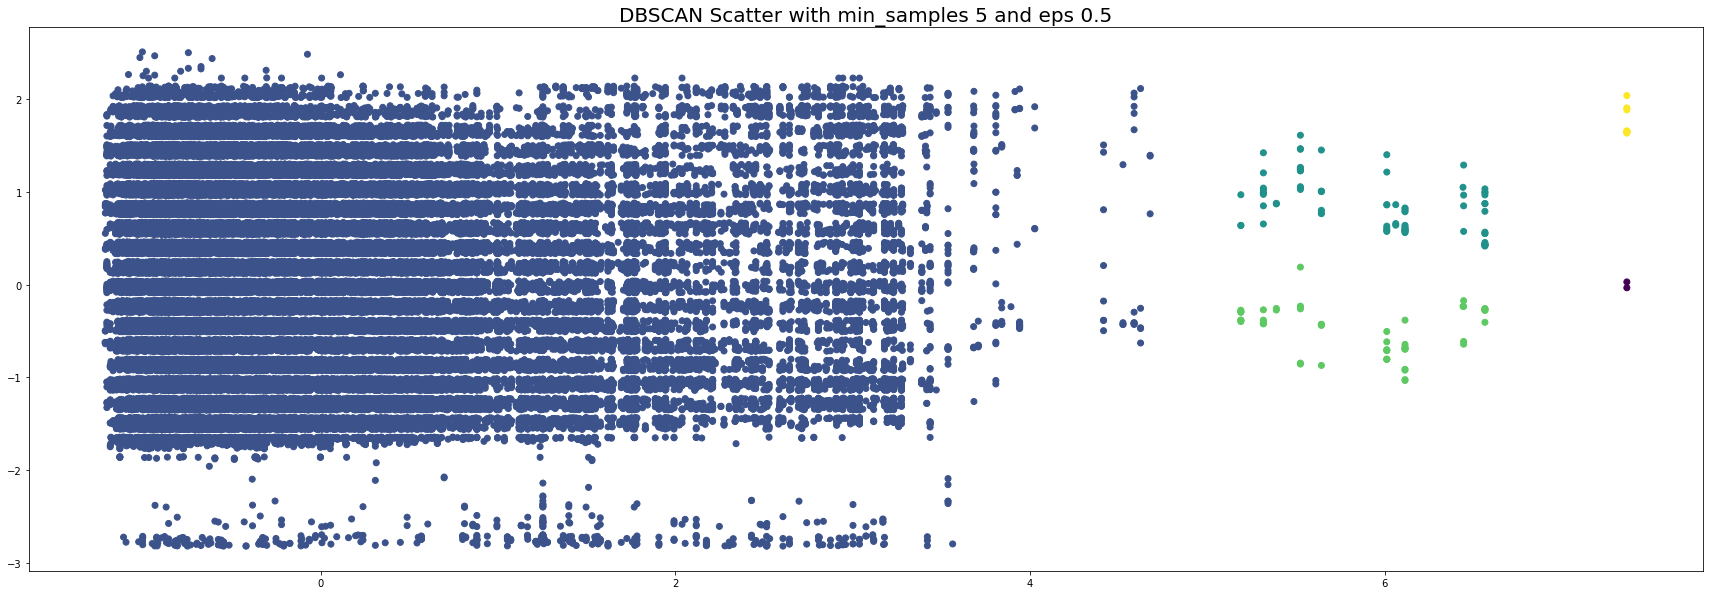

[[   -1     2]
 [    0 99853]
 [    1    80]
 [    2    56]
 [    3     9]]


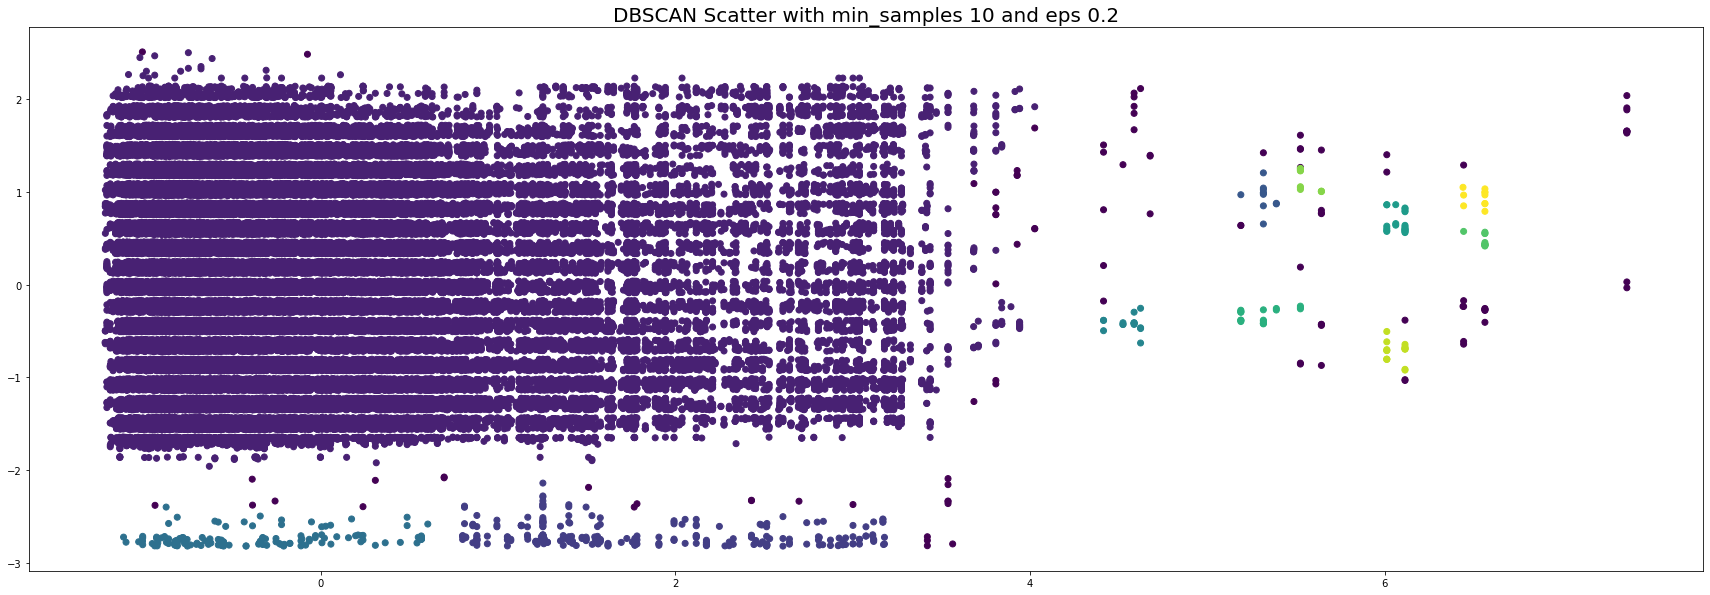

[[   -1   104]
 [    0 99384]
 [    1   257]
 [    2    11]
 [    3   138]
 [    4    16]
 [    5    22]
 [    6    19]
 [    7    12]
 [    8    11]
 [    9    16]
 [   10    10]]


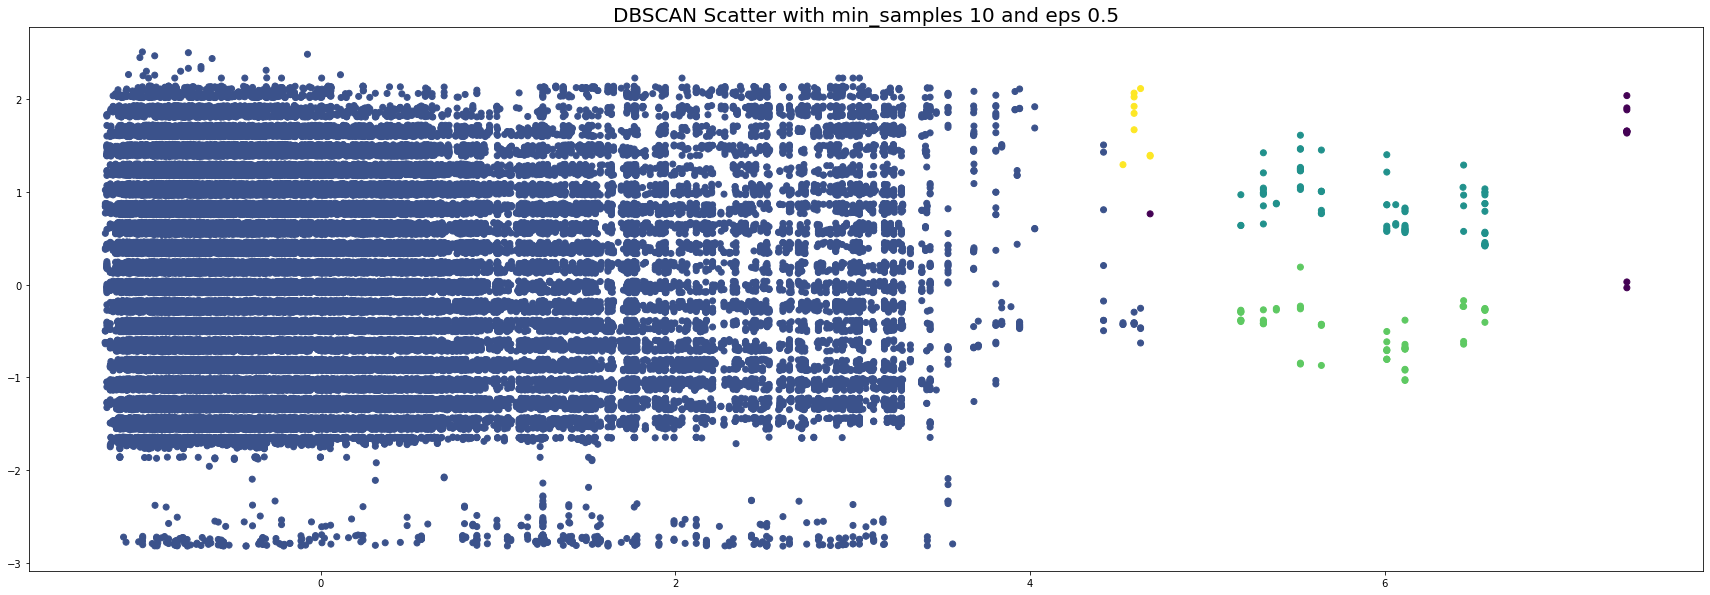

[[   -1    12]
 [    0 99843]
 [    1    80]
 [    2    56]
 [    3     9]]


In [ ]:
# your code here   ⟅⎛ꌩωꌩ⎞⟆
for k in [5, 10]:
  for e in [0.2, 0.5]:
    cls = DBSCAN(min_samples=k, eps = e)
    y = cls.fit_predict(df)
    plt.figure(figsize= (30,10))
    plt.scatter(df[:,0], df[:,1], c=y)
    plt.title(f'DBSCAN Scatter with min_samples {k} and eps {e}', fontsize=20)
    plt.show()
    unique, counts = np.unique(cls.labels_, return_counts=True)
    result = np.column_stack((unique, counts)) 
    print (result)

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

Будем исользовать дбскан с min_samples 10 and eps 0.2, кажется, что он лучше всего кластеризовал данные.

In [ ]:
# your code here  ¯\_(ツ)_/¯
cls = DBSCAN(min_samples=10, eps = 0.2)
y = cls.fit_predict(df)

In [ ]:
clusters = cls.labels_

In [ ]:
y = df_final['dep_delayed_15min']
dt = df_final.drop(columns='dep_delayed_15min')
dt["Cluster"] = clusters
dt_new = dt.apply(pd.to_numeric).values
y_target_new = y.apply(pd.to_numeric).to_numpy()

In [ ]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(dt_new, y_target_new, test_size=0.3)

In [ ]:
clf = CatBoostClassifier(learning_rate=0.1, depth = 5, early_stopping_rounds = 1, min_data_in_leaf = 1000, l2_leaf_reg = 100)
clf.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

0:	learn: 0.6417593	total: 14.9ms	remaining: 14.9s
1:	learn: 0.6027663	total: 30.1ms	remaining: 15s
2:	learn: 0.5739117	total: 44.5ms	remaining: 14.8s
3:	learn: 0.5492154	total: 59.3ms	remaining: 14.8s
4:	learn: 0.5288860	total: 74.1ms	remaining: 14.8s
5:	learn: 0.5135791	total: 90.5ms	remaining: 15s
6:	learn: 0.5012657	total: 105ms	remaining: 14.9s
7:	learn: 0.4928142	total: 119ms	remaining: 14.8s
8:	learn: 0.4858372	total: 134ms	remaining: 14.7s
9:	learn: 0.4792423	total: 148ms	remaining: 14.6s
10:	learn: 0.4744853	total: 163ms	remaining: 14.6s
11:	learn: 0.4703502	total: 178ms	remaining: 14.6s
12:	learn: 0.4666844	total: 193ms	remaining: 14.7s
13:	learn: 0.4640662	total: 208ms	remaining: 14.6s
14:	learn: 0.4610575	total: 226ms	remaining: 14.9s
15:	learn: 0.4590214	total: 240ms	remaining: 14.8s
16:	learn: 0.4573374	total: 255ms	remaining: 14.8s
17:	learn: 0.4562956	total: 270ms	remaining: 14.7s
18:	learn: 0.4553806	total: 285ms	remaining: 14.7s
19:	learn: 0.4539512	total: 301ms	remai

0.7423493612165675

__Ответ:__ Аук рок подрос, значит, объекты действительно кластеризовались хорошо.

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

https://drive.google.com/file/d/1fSM4ugQKtqjeAwstvUuGmkJEXX5xc5zB/view?usp=sharing

Провожу лето в окне в прямом и переносном смысле слова.

**+0.1 балла** за смешной мем по машинному обучению

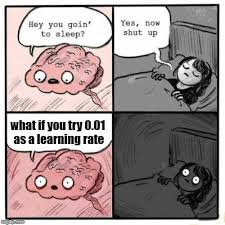

Это не мем, это муд этой домашки

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.